# Self-supervised DAS denoising 

In [ ]:
import gc
import h5py
import torch
import numpy as np
import torch.nn as nn
from das_util import try_gpu
from matplotlib import pyplot as plt
from numpy.random import default_rng
from scipy.signal import filtfilt, butter
from torch.utils.data import DataLoader
from das_denoise_models import unet, dataflow, datalabel
from das_denoise_training import train_augmentation
from sklearn.model_selection import train_test_split

### Option 1: read raw data

In [3]:
data_terra = '/fd1/QibinShi_data/akdas/qibin_data/TERRAtill2023_11_02.hdf5'
data_kkfls = '/fd1/QibinShi_data/akdas/qibin_data/KKFLStill2023_11_02.hdf5'
with h5py.File(data_terra, 'r') as f:
    quake1 = f['raw_quake'][:]
with h5py.File(data_kkfls, 'r') as f:
    quake2 = f['raw_quake'][:]
    
sample_rate = 25
delta_space = 10
    
tmp = np.append(quake2[:,:4500,:], quake1[:,:4500,:], axis=0)

b, a = butter(4, (0.5, 12), fs=sample_rate, btype='bandpass')
filt = filtfilt(b, a, tmp, axis=2)
rawdata = filt / np.std(filt, axis=(1,2), keepdims=True)

### Option 2: read the raw and FK-filtered data

In [ ]:
data_terra = '/fd1/QibinShi_data/akdas/qibin_data/TERRAtill2023_08_18.hdf5'
data_kkfls = '/fd1/QibinShi_data/akdas/qibin_data/KKFLStill2023_08_18.hdf5'
with h5py.File(data_terra, 'r') as f:
    quake1 = f['raw_quake'][:]
    label1 = f['fk_quake'][:]
with h5py.File(data_kkfls, 'r') as f:
    quake2 = f['raw_quake'][:]
    label2 = f['fk_quake'][:]
    
sample_rate = 25
delta_space = 10
    
tmp_q = np.append(quake2[:,:4500,:], quake1[:,:4500,:], axis=0)
tmp_l = np.append(label2[:,:4500,:], label1[:,:4500,:], axis=0)

b, a = butter(4, (0.5, 12), fs=sample_rate, btype='bandpass')
filt_q = filtfilt(b, a, tmp_q, axis=2)
filt_l = filtfilt(b, a, tmp_l, axis=2)
rawdata = filt_q / np.std(filt_q, axis=(1,2), keepdims=True)
fkdata = filt_l / np.std(filt_l, axis=(1,2), keepdims=True)

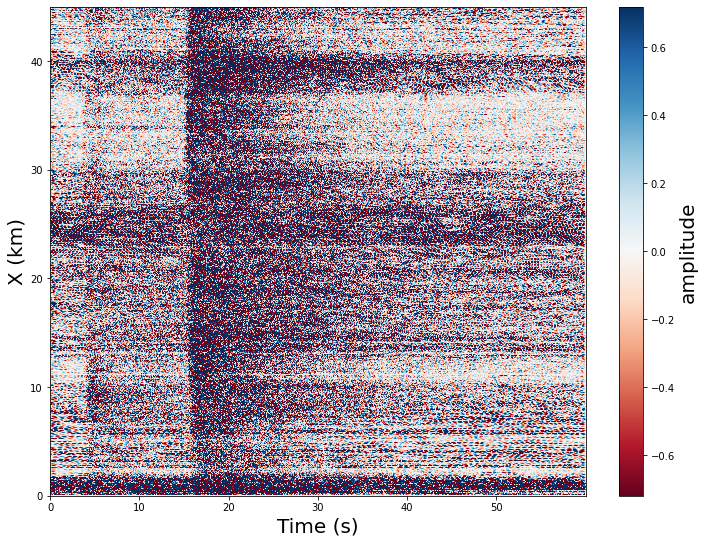

In [4]:
# %% visualize data
time_data = rawdata[5]
plt.figure(figsize=(12, 9)); cmap=plt.cm.get_cmap('RdBu'); max_amp = np.median(np.fabs(time_data))*2
x, y=np.arange(time_data.shape[1]), np.arange(time_data.shape[0])
plt.pcolormesh(x, y, time_data, shading='auto', vmin=-max_amp, vmax=max_amp, cmap=cmap)
plt.xticks(np.arange(0, 1500, 250), np.arange(0, 1500/sample_rate, 250/sample_rate).astype(int))
plt.yticks(np.arange(0, 4500, 1000), (np.arange(0, delta_space*4500, 1000*delta_space)/1000).astype(int))
plt.xlabel("Time (s)", fontsize=20); plt.ylabel("X (km)", fontsize=20)
cbr=plt.colorbar(); cbr.set_label('amplitude', fontsize = 20)

In [ ]:
# %% visualize label
time_data = fkdata[5]
plt.figure(figsize=(12, 9)); cmap=plt.cm.get_cmap('RdBu'); max_amp = np.median(np.fabs(time_data))*2
x, y=np.arange(time_data.shape[1]), np.arange(time_data.shape[0])
plt.pcolormesh(x, y, time_data, shading='auto', vmin=-max_amp, vmax=max_amp, cmap=cmap)
plt.xticks(np.arange(0, 1500, 250), np.arange(0, 1500/sample_rate, 250/sample_rate).astype(int))
plt.yticks(np.arange(0, 4500, 1000), (np.arange(0, delta_space*4500, 1000*delta_space)/1000).astype(int))
plt.xlabel("Time (s)", fontsize=20); plt.ylabel("X (km)", fontsize=20)
cbr=plt.colorbar(); cbr.set_label('amplitude', fontsize = 20)

### Option 1: input=target

In [5]:
# %% Shuffle and split dataset
X_tr, X, Y_tr, Y = train_test_split(rawdata, rawdata,
                                        train_size=0.7,
                                        random_state=111)
X_va, X_te, Y_va, Y_te = train_test_split(X, Y,
                                        train_size=0.5,
                                        random_state=121)

training_data = dataflow(X_tr, mask_ratio=0.5)
validation_data = dataflow(X_va, mask_ratio=0.5)
test_data = dataflow(X_te, mask_ratio=0.5)

del tmp, filt, rawdata, X, Y
gc.collect()

224

### Option 2: input !=target

In [ ]:
# %% Shuffle and split dataset
X_tr, X, Y_tr, Y = train_test_split(rawdata, fkdata,
                                        train_size=0.7,
                                        random_state=111)
X_va, X_te, Y_va, Y_te = train_test_split(X, Y,
                                        train_size=0.5,
                                        random_state=121)

training_data = datalabel(X_tr, Y_tr, mask_ratio=0.5)
validation_data = datalabel(X_va, Y_va, mask_ratio=0.5)
test_data = datalabel(X_te, Y_te, mask_ratio=0.5)

del tmp_q, tmp_l, filt_q, filt_l, rawdata, fkdata, X, Y
gc.collect()

In [ ]:
print(len(training_data), len(validation_data))

### Construct the neural network

In [6]:
""" Initialize the U-net model """
model = unet(1, 16, 1024, factors=(5, 3, 2, 2), use_att=False)
devc = try_gpu(i=0)
model = nn.DataParallel(model, device_ids=[0,1,2,3])  # comment if gpus<4 
model.to(devc)

DataParallel(
  (module): unet(
    (relu): ReLU()
    (layer): ModuleList(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): MaxBlurPool2d()
      (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): MaxBlurPool2d()
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): MaxBlurPool2d()
      (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): Dropout(p=0.2, inplace=False)
      (12): MaxBlurPool2d()
      (13): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1

### Training

In [7]:
# %% Hyper-parameters for training
batch_size = 64
lr = 1e-4
loss_fn = nn.MSELoss()
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
lr_schedule = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                         mode='min', 
                                                         factor=0.8, 
                                                         patience=5, 
                                                         threshold=0.001, 
                                                         threshold_mode='rel', 
                                                         cooldown=0, 
                                                         min_lr=1e-6, 
                                                         eps=1e-08, 
                                                         verbose=True)

train_iter = DataLoader(training_data, batch_size=batch_size, shuffle=False)
validate_iter = DataLoader(validation_data, batch_size=batch_size, shuffle=False)

In [8]:
model, \
avg_train_losses, \
avg_valid_losses = train_augmentation(train_iter,
                                   validate_iter,
                                   model,
                                   loss_fn,
                                   optimizer,
                                   lr_schedule=lr_schedule,
                                   epochs=350,
                                   patience=20,
                                   device=devc,
                                   minimum_epochs=50)

[  1/350] train_loss: 7.46093 valid_loss: 0.38333 time per epoch: 308.054 s
[  2/350] train_loss: 0.36469 valid_loss: 0.35352 time per epoch: 289.479 s
[  3/350] train_loss: 0.33686 valid_loss: 0.32513 time per epoch: 323.281 s
[  4/350] train_loss: 0.31536 valid_loss: 0.30748 time per epoch: 299.079 s
[  5/350] train_loss: 0.30254 valid_loss: 0.29494 time per epoch: 295.333 s
[  6/350] train_loss: 0.29324 valid_loss: 0.28624 time per epoch: 294.593 s
[  7/350] train_loss: 0.28679 valid_loss: 0.28105 time per epoch: 307.754 s
[  8/350] train_loss: 0.28284 valid_loss: 0.27750 time per epoch: 331.978 s
[  9/350] train_loss: 0.27948 valid_loss: 0.27427 time per epoch: 326.560 s
[ 10/350] train_loss: 0.27563 valid_loss: 0.27044 time per epoch: 325.665 s
[ 11/350] train_loss: 0.27236 valid_loss: 0.26764 time per epoch: 319.824 s
[ 12/350] train_loss: 0.26979 valid_loss: 0.26532 time per epoch: 314.803 s
[ 13/350] train_loss: 0.26755 valid_loss: 0.26330 time per epoch: 306.729 s
[ 14/350] tr

[ 84/350] train_loss: 0.21952 valid_loss: 0.21932 time per epoch: 368.610 s
EarlyStopping counter: 1 out of 20
[ 85/350] train_loss: 0.21891 valid_loss: 0.21928 time per epoch: 405.463 s
EarlyStopping counter: 2 out of 20
[ 86/350] train_loss: 0.21907 valid_loss: 0.21914 time per epoch: 407.643 s
Validation loss decreased (0.219195 --> 0.219142).  Saving model ...
[ 87/350] train_loss: 0.21860 valid_loss: 0.21914 time per epoch: 372.063 s
Validation loss decreased (0.219142 --> 0.219140).  Saving model ...
[ 88/350] train_loss: 0.21839 valid_loss: 0.21911 time per epoch: 321.916 s
Validation loss decreased (0.219140 --> 0.219106).  Saving model ...
[ 89/350] train_loss: 0.21814 valid_loss: 0.21881 time per epoch: 316.335 s
Validation loss decreased (0.219106 --> 0.218808).  Saving model ...
[ 90/350] train_loss: 0.21806 valid_loss: 0.21904 time per epoch: 316.009 s
EarlyStopping counter: 1 out of 20
[ 91/350] train_loss: 0.21803 valid_loss: 0.21851 time per epoch: 329.535 s
Validation 

[146/350] train_loss: 0.21116 valid_loss: 0.21555 time per epoch: 315.344 s
EarlyStopping counter: 2 out of 20
[147/350] train_loss: 0.21109 valid_loss: 0.21536 time per epoch: 305.772 s
EarlyStopping counter: 3 out of 20
[148/350] train_loss: 0.21101 valid_loss: 0.21550 time per epoch: 305.871 s
EarlyStopping counter: 4 out of 20
[149/350] train_loss: 0.21097 valid_loss: 0.21544 time per epoch: 306.573 s
EarlyStopping counter: 5 out of 20
Epoch 00150: reducing learning rate of group 0 to 3.2768e-05.
[150/350] train_loss: 0.21095 valid_loss: 0.21575 time per epoch: 308.355 s
EarlyStopping counter: 6 out of 20
[151/350] train_loss: 0.21088 valid_loss: 0.21548 time per epoch: 308.350 s
EarlyStopping counter: 7 out of 20
[152/350] train_loss: 0.21081 valid_loss: 0.21551 time per epoch: 312.626 s
EarlyStopping counter: 8 out of 20
[153/350] train_loss: 0.21076 valid_loss: 0.21547 time per epoch: 312.275 s
EarlyStopping counter: 9 out of 20
[154/350] train_loss: 0.21069 valid_loss: 0.21543 

Epoch 00210: reducing learning rate of group 0 to 4.3980e-06.
[210/350] train_loss: 0.20921 valid_loss: 0.21416 time per epoch: 308.332 s
EarlyStopping counter: 2 out of 20
[211/350] train_loss: 0.20919 valid_loss: 0.21418 time per epoch: 310.197 s
EarlyStopping counter: 3 out of 20
[212/350] train_loss: 0.20918 valid_loss: 0.21408 time per epoch: 311.360 s
Validation loss decreased (0.214103 --> 0.214085).  Saving model ...
[213/350] train_loss: 0.20918 valid_loss: 0.21421 time per epoch: 310.312 s
EarlyStopping counter: 1 out of 20
[214/350] train_loss: 0.20916 valid_loss: 0.21412 time per epoch: 312.464 s
EarlyStopping counter: 2 out of 20
[215/350] train_loss: 0.20916 valid_loss: 0.21409 time per epoch: 335.385 s
EarlyStopping counter: 3 out of 20
Epoch 00216: reducing learning rate of group 0 to 3.5184e-06.
[216/350] train_loss: 0.20915 valid_loss: 0.21412 time per epoch: 331.530 s
EarlyStopping counter: 4 out of 20
[217/350] train_loss: 0.20913 valid_loss: 0.21409 time per epoch:

Text(0.5, 1.0, 'loss curves')

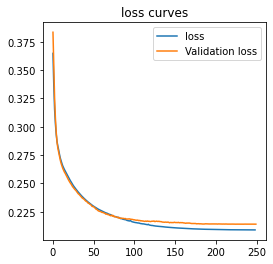

In [12]:
# %% Show loss evolution when training is done
loss = avg_train_losses
val_loss = avg_valid_losses
plt.figure(figsize=(4, 4))
plt.plot(loss[1:], '-', label='loss')
plt.plot(val_loss, '-', label='Validation loss')
plt.legend()
plt.title('loss curves')
# plt.savefig(model_dir + f'/{model_name}_Training_history.png')

### Testing 

In [13]:
test_data = dataflow(X_te[:,500:2000,:], stride=1500, mask_ratio=0.2, n_masks=1)
print(len(test_data))

85


[Text(0, 0, '0'),
 Text(0, 200, '2'),
 Text(0, 400, '4'),
 Text(0, 600, '6'),
 Text(0, 800, '8'),
 Text(0, 1000, '10'),
 Text(0, 1200, '12'),
 Text(0, 1400, '14')]

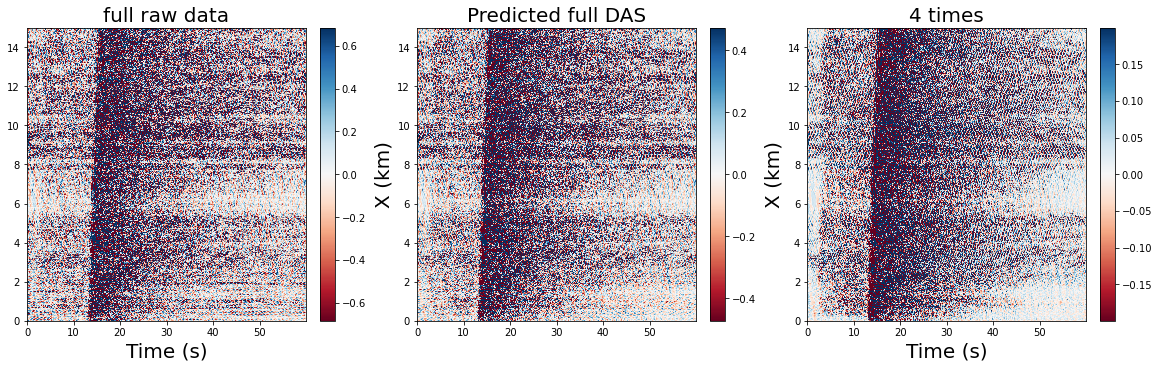

In [52]:
# %% numpy arrays
ind = 2

(X, mask), y = test_data[ind:ind+1]

# %% convert to torch tensors
X = torch.from_numpy(X).to(devc)
mask = torch.from_numpy(mask).to(devc)

# inputdata=X*mask
inputdata=X
maskdata=X*(1-mask)


# %% make a prediction use the best model
model.eval() 
with torch.no_grad():
    pred = model(inputdata)
    tmp = model(pred)
    tmp = model(tmp)
    tmp = model(tmp)


    
# %% convert back to numpy for plotting
inputdata = inputdata[0,0].to('cpu').numpy()
inputdata = tmp[0,0].to('cpu').numpy()
maskdata = maskdata[0,0].to('cpu').numpy()
rawdata = X[0,0].to('cpu').numpy()
pred = pred[0,0].to('cpu').numpy()
# pred = (pred-np.mean(pred))/np.std(pred)


# visualize all
fig, ax = plt.subplots(1, 3, figsize=(16, 5), constrained_layout=True)

x, y = np.arange(pred.shape[1]), np.arange(pred.shape[0])

max_amp = np.median(np.fabs(rawdata)) *2 
img=ax[0].pcolormesh(x, y, rawdata, shading='auto', vmin=-max_amp, vmax=max_amp, cmap=cmap)
plt.colorbar(img, ax=ax[0])

ax[0].set_xlabel("Time (s)", fontsize=20)
ax[0].set_xticks(np.arange(0, 1500, 250)) 
ax[0].set_xticklabels(np.arange(0, 1500/sample_rate, 250/sample_rate).astype(int))
ax[0].set_title("full raw data", fontsize=20)
ax[0].set_yticks(np.arange(0, 1500, 200))
ax[0].set_yticklabels((np.arange(0, delta_space*1500, 200*delta_space)/1000).astype(int))

max_amp = np.median(np.fabs(pred))*2
img=ax[1].pcolormesh(x, y, pred, shading='auto', vmin=-max_amp, vmax=max_amp, cmap=cmap)
plt.colorbar(img, ax=ax[1])

ax[1].set_title("Predicted full DAS", fontsize=20)
ax[1].set_xticks(np.arange(0, 1500, 250)) 
ax[1].set_xticklabels(np.arange(0, 1500/sample_rate, 250/sample_rate).astype(int))
ax[1].set_ylabel("X (km)", fontsize=20)
ax[1].set_yticks(np.arange(0, 1500, 200))
ax[1].set_yticklabels((np.arange(0, delta_space*1500, 200*delta_space)/1000).astype(int))

max_amp = np.median(np.fabs(inputdata))*2
img=ax[2].pcolormesh(x, y, inputdata, shading='auto', vmin=-max_amp, vmax=max_amp, cmap=cmap)
plt.colorbar(img, ax=ax[2])

ax[2].set_title("4 times", fontsize=20)
ax[2].set_xlabel("Time (s)", fontsize=20)
ax[2].set_xticks(np.arange(0, 1500, 250)) 
ax[2].set_xticklabels(np.arange(0, 1500/sample_rate, 250/sample_rate).astype(int))
ax[2].set_ylabel("X (km)", fontsize=20)
ax[2].set_yticks(np.arange(0, 1500, 200))
ax[2].set_yticklabels((np.arange(0, delta_space*1500, 200*delta_space)/1000).astype(int))